# Stage 1: Importing dependencies.

In [0]:
from google.colab import drive
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
import re

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Stage 2: Data preprocessing

## Loading files

In [19]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [20]:
ls "/content/drive/My Drive"


'Colab Notebooks'/  'Getting started.pdf'   projects/


In [0]:
cols = ["sentiment", "id", "date", "query", "user", "text"]
train_data = pd.read_csv(
    "/content/drive/My Drive/projects/CNN_for_NLP/train.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [22]:
data = train_data
print(data.shape)
data.head()

(1600000, 6)


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cac82ca90>,
      dtype=object)

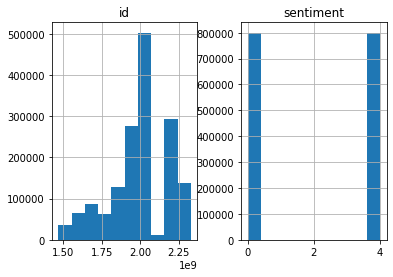

In [23]:
data.hist()

## Preprocessing

### Cleaning

In [0]:
data.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

In [0]:
def prepare_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # Remove URL
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)           # Remove non-character elements
    tweet = re.sub(r" +", ' ', tweet)                      # Remove whitespaces
    return tweet

In [0]:
data_list = [prepare_tweet(tweet) for tweet in data.text]

In [0]:
class_labels = data.sentiment.values
class_labels[class_labels == 4] = 1



### Tokenization

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_list, 
                                                                    target_vocab_size=2**16)

data_list = [tokenizer.encode(sentence) for sentence in data_list]

### Padding

In [0]:
# Resize all sentences to MAX_LEN by padding zeros
MAX_LEN   = max([len(sentence) for sentence in data_list])
data_list = tf.keras.preprocessing.sequence.pad_sequences(data_list,
                                                          value=0,
                                                          padding="post",
                                                          maxlen=MAX_LEN)

### Spliting into training/testing set



In [30]:
test_idx = np.random.randint(0, 800000, 8000)
test_idx = np.concatenate((test_idx, test_idx+800000))
test_idx.size

16000

In [0]:
test_list     = data_list[test_idx]
test_classes  = class_labels[test_idx]
train_list    = np.delete(data_list, test_idx, axis=0)
train_classes = np.delete(class_labels, test_idx)

# Stage 3: Model building

In [0]:
#CNN architecture implemented as a class for reusability
class CNN(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(CNN, self).__init__(name=name)
        
        #Embedding provided in keras modules, Understanding: https://keras.io/api/layers/core_layers/embedding/
        # https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

        self.embedding = layers.Embedding(vocabulary_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        region    = self.embedding(inputs)
        region_1  = self.bigram(region)
        region_1  = self.pool(region_1)
        region_2  = self.trigram(region)
        region_2  = self.pool(region_2)
        region_3  = self.fourgram(region)
        region_3  = self.pool(region_3)
        
        merged = tf.concat([region_1, region_2, region_3], axis=-1) #concate w.r.t to the last axis
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Stage 4: Application

## Config

In [0]:
# Standard pre-requisites for CNN architecture

VOCABULARY_SIZE = tokenizer.vocab_size

EMB_DIM = 200                             #embedding dimension
NB_FILTERS = 100                          #number of filters
FFN_UNITS = 256                           #feed-forward network units (number of neurons)
NB_CLASSES = len(set(train_classes))      #number of classes 

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5                             #number of epochs

## Training

In [0]:
Cnn = CNN(vocabulary_size=VOCABULARY_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [0]:
# binary_crossentropy for 2 - class data & sparse_categorical_crossentropy for >2 - class data
if NB_CLASSES == 2:
    Cnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    # Details: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class    
    Cnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [0]:
# Since the execution of the next cell(model training) may take hours,
# it is safe have checkpoints to save epochs of training to prevent loss of learning due to technical faults
 
checkpoint_path = "./drive/My Drive/projects/CNN_for_NLP/ckpt/"

checkpoint = tf.train.Checkpoint(Cnn=Cnn)
# Max number of checkpoints to be maintained is 10, to minimize memory usage
checkpoint_mgr = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=10) 

if checkpoint_mgr.latest_checkpoint:
    checkpoint.restore(checkpoint_mgr.latest_checkpoint)
    print("Last checkpoint retrieved")

In [29]:
Cnn.fit(train_list,
        train_classes,
        batch_size=BATCH_SIZE,
        epochs=NB_EPOCHS)
checkpoint_mgr.save()

Epoch 1/5
49503/49503 [==============================] - 5545s 112ms/step - loss: 0.3981 - accuracy: 0.8201
Epoch 2/5
49503/49503 [==============================] - 5467s 110ms/step - loss: 0.3333 - accuracy: 0.8574
Epoch 3/5
49503/49503 [==============================] - 5483s 111ms/step - loss: 0.2814 - accuracy: 0.8833
Epoch 4/5
49503/49503 [==============================] - 5464s 110ms/step - loss: 0.2290 - accuracy: 0.9077
Epoch 5/5
49503/49503 [==============================] - 5463s 110ms/step - loss: 0.1844 - accuracy: 0.9271


'./drive/My Drive/projects/CNN_for_NLP/ckpt/ckpt-1'

## Evaluation

In [0]:
results = Cnn.evaluate(test_list, test_classes, batch_size=BATCH_SIZE)
print(results)

In [37]:
np.array([tokenizer.encode("Empty vessels make more noise")]), training=False)

array([[ 135,   39,   21, 1034]])